How does our TFR (with the 0pt calibrated with the EDD, and jointly fit to the TFR) compare with that of Cosmicflows-4?

Also, how do our rotational velocities compare with ALFALFA's (which is what Cosmicflows-4 used)?

In [7]:
import numpy as np

from astropy.table import Table, unique, join
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.constants as const

import pickle

from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## fuji

In [3]:
# tfuji_all = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
# tfuji_all = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
# tfuji = unique(tfuji_all)
tfuji = Table.read('SGA_fuji_jointTFR-varyV0-perpdwarf-zCMB_moduli_pec-Watkins15.fits')
tfuji[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_ERR,TARGETID,PHOTSYS,Z_DESI_CMB,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,MU_zCMB,MU_zCMB_ERR,R_ABSMAG_SB26,R_ABSMAG_SB26_ERR,R_ABSMAG_SB26_CORR,R_ABSMAG_SB26_CORR_ERR,R_ABSMAG_SB26_TFbright,R_ABSMAG_SB26_TFbright_err,MU_TFbright,MU_TFbright_ERR,LOGDIST,LOGDIST_ERR,V_PEC,VERR_PEC
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,int64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.00574

## SGA

Read in our version of the SGA that includes the index value of the galaxy in the ALFALFA data file.  (This file was made with the `ALFALFA_radec_match.py` script, currently living in my (Kelly's) data folder on my local machine.)

In [4]:
SGA = Table.read('/pscratch/sd/k/kadglass/data/SGA-2020_ALFALFA.fits')
# SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020_ALFALFA.fits')

SGA['ALFALFA_index'].name = 'ALFALFA_AGCNr'

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,ALFALFA_AGCNr
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0,-1
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.544437500000

### Copy the ALFALFA index column over into our fuji table

In [8]:
tfuji_SGA = join(tfuji, SGA['SGA_ID', 'ALFALFA_AGCNr'], keys='SGA_ID')

In [10]:
# Rename this as the SGA table so that we don't have to change everything below
SGA = tfuji_SGA

## ALFALFA

In [5]:
ALFALFA = Table.read('/pscratch/sd/k/kadglass/data/a100.code12.table2.190808.txt', 
# ALFALFA = Table.read('/Users/kdouglass/Documents/Research/data/ALFALFA/a100.code12.table2.190808.txt',
                     format='ascii.csv', 
                     include_names=['AGCNr', 'W50', 'sigW', 'W20'])

ALFALFA[:5]

AGCNr,W50,sigW,W20
int64,int64,int64,int64
105367,274,39,281
333313,313,20,333
331060,160,4,184
331061,260,45,268
104570,245,6,250


In [9]:
ALFALFA_dict = {}

for i in range(len(ALFALFA)):
    
    ALFALFA_dict[ALFALFA['AGCNr'][i]] = i

## If an SGA galaxy has at least one observation at its center, set the HI velocity of that galaxy

In [11]:
SGA['V_HI'] = np.nan
SGA['VERR_HI'] = np.nan
SGA['V20_HI'] = np.nan

for i in range(len(SGA)):
    
    # Set the HI velocity width of this galaxy
    if SGA['ALFALFA_AGCNr'][i] >= 0:
        
        ALFALFA_idx = ALFALFA_dict[SGA['ALFALFA_AGCNr'][i]]
        
        SGA['V_HI'][i] = ALFALFA['W50'][ALFALFA_idx] - 6. # Adjustment from Kourkchi et al. (2020a), Sec. 2.2
        SGA['VERR_HI'][i] = ALFALFA['sigW'][ALFALFA_idx]
        SGA['V20_HI'][i] = ALFALFA['W20'][ALFALFA_idx]

### Filter SGA to keep only those objects with HI velocities

In [31]:
HI = np.isfinite(SGA['V_HI'])

################################################################################
# Keep all observations of each galaxy that have HI velocities
#-------------------------------------------------------------------------------
SGA_HI = SGA[HI]
################################################################################

print('fuji galaxies with HI velocities:', len(SGA_HI))

fuji galaxies with HI velocities: 146


## Cut for galaxies with HI velocities suitable for calibrating the TFR

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$ (already applied)
* $\Delta V/V_{min} \leq 5$ (already applied)
* $i > 45^\circ$
* Spiral-type morphology
* Passes visual inspection

### Inclination angle cut

In [32]:
SGA_HI['cosi2'] = (SGA_HI['BA']**2 - q0**2)/(1 - q0**2)
SGA_HI['cosi2'][SGA_HI['cosi2'] < 0] = 0

i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = SGA_HI['cosi2'] <= cosi2_max

SGA_HI_edge = SGA_HI[edge]

print(len(SGA_HI_edge))

122


### Morphology cut

In [33]:
spirals = np.zeros(len(SGA_HI_edge), dtype=bool)

for i in range(len(SGA_HI_edge)):

    try:
        if (SGA_HI_edge['MORPHTYPE'][i][0] == 'S') and (SGA_HI_edge['MORPHTYPE'][i][:2] != 'SO'):
            spirals[i] = True
    except IndexError:
        print(SGA_HI_edge['MORPHTYPE'][i])

SGA_HI_edge_spirals = SGA_HI_edge[spirals]

print(len(SGA_HI_edge_spirals))

--
--
--
--
105


In [34]:
# Make a catalog of just those galaxies with HI velocities
SGA_0pt = SGA_HI_edge_spirals

## Compute the absolute magnitudes based on the Cosmicflows-4 TFR

### First, we need to correct the HI velocities for the inclination angle.

In [35]:
SGA_0pt['V_HI_CORR'] = SGA_0pt['V_HI']/np.sin(np.arccos(np.sqrt(SGA_0pt['cosi2'])))
SGA_0pt['VERR_HI_CORR'] = SGA_0pt['VERR_HI']/np.sin(np.arccos(np.sqrt(SGA_0pt['cosi2'])))

SGA_0pt['V20_HI_CORR'] = SGA_0pt['V20_HI']/np.sin(np.arccos(np.sqrt(SGA_0pt['cosi2'])))

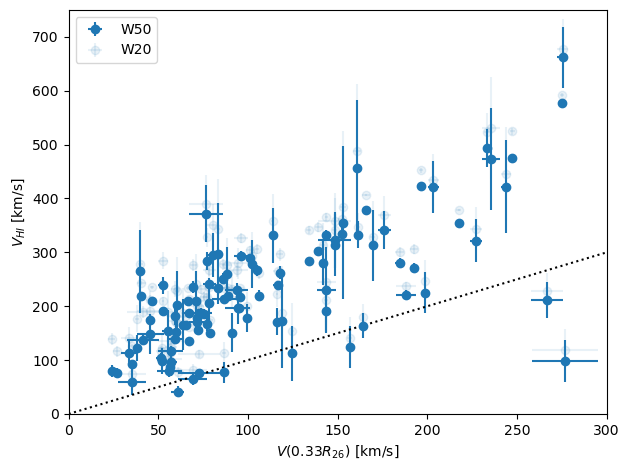

In [36]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_0pt['V_0p33R26'], SGA_0pt['V_HI_CORR'], 
             xerr=SGA_0pt['V_0p33R26_ERR'], 
             yerr=SGA_0pt['VERR_HI_CORR'], 
             fmt='o', 
             # alpha=0.1, 
             label='W50')
plt.errorbar(SGA_0pt['V_0p33R26'], SGA_0pt['V20_HI_CORR'], 
             xerr=SGA_0pt['V_0p33R26_ERR'], 
             yerr=SGA_0pt['VERR_HI_CORR'], 
             fmt='o', 
             alpha=0.1,
             c='tab:blue', 
             label='W20')

plt.plot([0, 800], [0, 800], 'k:')

# plt.hlines(90, 0, 300, colors='r', linestyles='dashed', label='W20 = 90 km/s')

plt.xlim([0, 300])
plt.ylim([0, 750])

plt.legend()

plt.xlabel('$V(0.33R_{26})$ [km/s]')
plt.ylabel('$V_{HI}$ [km/s]');

### Now, we use the Tully-Fisher relation calibrated by Cosmicflows-4 (Kourkchi+ 2020) to calculate the absolute magnitudes of these galaxies

Cosmicflows-4 TF calibration:
\begin{equation}
  \overline{M_\lambda} = \text{Slope} \left( \log W^i_{mx} - 2.5 \right) + \overline{\text{ZP}}
\end{equation}
where
\begin{equation}
  \overline{\text{ZP}} = \text{ZP} + C_{zp}
\end{equation}
is a correction to the zero-point to account for slightly different distance moduli found with different passbands for the same clusters.

For the $r$-band, the parameter values are
 * slope $= -7.96\pm 0.13$
 * ZP $= -20.57\pm 0.10$
 * $C_{zp} = -0.08\pm 0.13$
 * $\sigma = 0.49$ (for cluster calibrators)

In [37]:
CF4_slope = -7.96
CF4_slope_err = 0.13

CF4_ZP = -20.57
CF4_ZP_err = 0.10

CF4_Czp = -0.08
CF4_Czp_err = 0.13

CF4_sig = 0.49

SGA_0pt['R_ABSMAG_SB26_CF4'] = CF4_slope*(np.log10(SGA_0pt['V_HI_CORR'] - 6) - 2.5) + CF4_ZP + CF4_Czp
#SGA_0pt['R_ABSMAG_SB26_CF4_err'] = np.sqrt((np.log10(SGA_0pt['V_HI_corr'] - 6) - 2.5)**2 * CF4_slope_err**2 + (CF4_slope/((SGA_0pt['V_HI_corr'] - 6)*np.log(10)))**2 * SGA_0pt['VERR_HI_corr']**2 + CF4_ZP_err**2 + CF4_Czp_err**2)

In [38]:
N_samples = 100000

rng = np.random.default_rng()

m_random = rng.normal(CF4_slope, CF4_slope_err, size=N_samples)
b_random = rng.normal(CF4_ZP, CF4_ZP_err, size=N_samples)
bp_random = rng.normal(CF4_Czp, CF4_Czp_err, size=N_samples)

SGA_0pt['R_ABSMAG_SB26_CF4_ERR'] = np.nan
SGA_0pt['R_ABSMAG_SB26_CF4_ERR_STAT'] = np.nan

for i in range(len(SGA_0pt)):
    
    v_random = rng.normal(SGA_0pt['V_HI_CORR'][i], 
                          SGA_0pt['VERR_HI_CORR'][i], 
                          size=N_samples)
    
    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = CF4_slope*(np.log10(v_random - 6) - 2.5) + CF4_ZP + CF4_Czp
    
    SGA_0pt['R_ABSMAG_SB26_CF4_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################
    
    
    ############################################################################
    # Total uncertainty
    #---------------------------------------------------------------------------
    Ms = m_random*(np.log10(v_random - 6) - 2.5) + b_random + bp_random
    
    SGA_0pt['R_ABSMAG_SB26_CF4_ERR'][i] = np.nanstd(Ms)
    ############################################################################
    
    
################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
SGA_0pt['R_ABSMAG_SB26_CF4_ERR_SYS'] = np.sqrt(SGA_0pt['R_ABSMAG_SB26_CF4_ERR']**2 - SGA_0pt['R_ABSMAG_SB26_CF4_ERR_STAT']**2)
################################################################################

/tmp/ipykernel_1412222/942879918.py:21: RuntimeWarning: invalid value encountered in log10
  Ms_stat = CF4_slope*(np.log10(v_random - 6) - 2.5) + CF4_ZP + CF4_Czp
/tmp/ipykernel_1412222/942879918.py:30: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random - 6) - 2.5) + b_random + bp_random


## Compute the absolute magnitudes based on our TFR

Here, the slope and 0-pt are from `joint-Coma-0pt_Fuji-TFR_KAD_varyV0-perpdwarfs_AnthonyUpdated_weightsVmax-1.ipynb`:

\begin{equation}
  M_r = a (\log(V(0.33R_{26})) - V_0) + b
\end{equation}

In [39]:
temp_infile = open('cov_ab_fuji_joint_TFR_varyV0-perpdwarfs0_AnthonyUpdates_weightsVmax-1_KAD.pickle', 
                   'rb')
cov_ab, tfr_samples, V0 = pickle.load(temp_infile)
temp_infile.close()

our_slope = np.median(tfr_samples[0])
our_ZP = np.median(tfr_samples[2])
our_sig = np.median(tfr_samples[-1])

print(our_slope, our_ZP, V0)

-7.70487935423971 -19.45064163251238 2.0098860234777294


In [40]:
SGA_0pt['R_ABSMAG_SB26_US'] = our_slope*(np.log10(SGA_0pt['V_0p33R26']) - V0) + our_ZP

In [41]:
m_random = tfr_samples[0]
b_random = tfr_samples[2]

N_samples = len(m_random)

SGA_0pt['R_ABSMAG_SB26_US_ERR'] = np.nan
SGA_0pt['R_ABSMAG_SB26_US_ERR_STAT'] = np.nan # Statistical uncertainty (just due to the uncertainty in the velocity)

for i in range(len(SGA_0pt)):
    
    v_random = rng.normal(SGA_0pt['V_0p33R26'][i], 
                          SGA_0pt['V_0p33R26_ERR'][i], 
                          size=N_samples)
    
    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = our_slope*(np.log10(v_random) - V0) + our_ZP
    
    SGA_0pt['R_ABSMAG_SB26_US_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################
    
    
    ############################################################################
    # Total uncertainty
    #---------------------------------------------------------------------------
    Ms = m_random*(np.log10(v_random) - V0) + b_random
    
    SGA_0pt['R_ABSMAG_SB26_US_ERR'][i] = np.nanstd(Ms)
    ############################################################################

    
    
################################################################################
# Systematic uncertainty (due to the uncertainty in the fit)
#-------------------------------------------------------------------------------
SGA_0pt['R_ABSMAG_SB26_US_ERR_SYS'] = np.sqrt(SGA_0pt['R_ABSMAG_SB26_US_ERR']**2 - SGA_0pt['R_ABSMAG_SB26_US_ERR_STAT']**2)
################################################################################

/tmp/ipykernel_1412222/553596949.py:18: RuntimeWarning: invalid value encountered in log10
  Ms_stat = our_slope*(np.log10(v_random) - V0) + our_ZP
/tmp/ipykernel_1412222/553596949.py:27: RuntimeWarning: invalid value encountered in log10
  Ms = m_random*(np.log10(v_random) - V0) + b_random


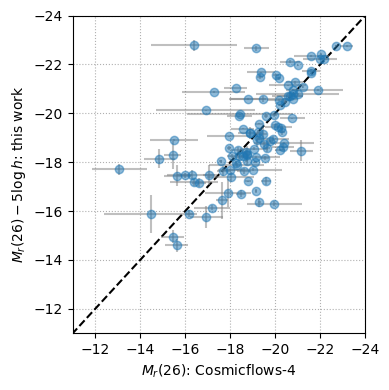

In [43]:
plt.figure(figsize=(4,4), tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], 'k--')

plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'], SGA_0pt['R_ABSMAG_SB26_US'], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_ERR_STAT'], 
             yerr=SGA_0pt['R_ABSMAG_SB26_US_ERR_STAT'], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray'
            )

plt.xlim([-11, -24])
plt.ylim([-11, -24])

plt.xlabel('$M_r(26)$: Cosmicflows-4')
plt.ylabel('$M_r(26) - 5\log h$: this work');

In [44]:
# Restrict the sample to the range allowed by the Cosmicflows-4 calibration

StoN = SGA_0pt['V_HI']/SGA_0pt['VERR_HI']

CF4_boolean = (StoN > 10) & ((SGA_0pt['V_HI_CORR'] - 6) > 64)

print(sum(CF4_boolean))

56


In [45]:
# Mark dwarf galaxies differently
logV_n17 = (-17 - our_ZP)/our_slope + V0
b_perp = -17 + (logV_n17 - V0)/our_slope

dwarf_boolean = (SGA_0pt['R_ABSMAG_SB26_US'] - SGA_0pt['R_ABSMAG_SB26_US_ERR']) > (-(np.log10(SGA_0pt['V_0p33R26']) - V0)/our_slope + b_perp)

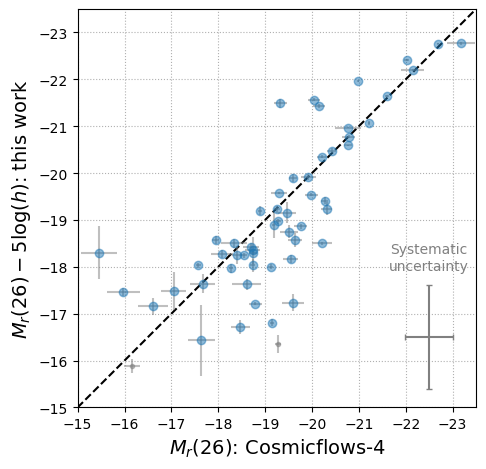

In [58]:
H0 = 76.0 # From Kourkchi et al. (2020a)
h = H0/100

#plt.figure(figsize=(4,4), tight_layout=True)
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], '--', color='k')#'lightgray')
# plt.plot([-5, -28], np.array([-5, -28]) - 5*np.log(h), 'k--') # with H0 from Cosmicflows 4

plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & ~dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_US'][CF4_boolean & ~dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_ERR_STAT'][CF4_boolean & ~dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_US_ERR_STAT'][CF4_boolean & ~dwarf_boolean], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_US'][CF4_boolean & dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_ERR_STAT'][CF4_boolean & dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_US_ERR_STAT'][CF4_boolean & dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

# Systematic error bar example
plt.errorbar([-22.5], [-16.5], 
             xerr=np.sqrt(np.nanmean(SGA_0pt['R_ABSMAG_SB26_CF4_ERR_SYS'][CF4_boolean])**2 + CF4_sig**2),
             yerr=np.sqrt(np.nanmean(SGA_0pt['R_ABSMAG_SB26_US_ERR_SYS'][CF4_boolean])**2 + our_sig**2), 
             # fmt='x', 
             # color='lightgray',
             ecolor='gray', 
             capsize=2)
plt.annotate('Systematic\nuncertainty', 
             (-22.5, -18.2), 
             #rotation='vertical', 
             va='center',
             ha='center',
             c='gray')

plt.gca().set_aspect('equal')

plt.xlim([-15, -23.5])
plt.ylim([-15, -23.5])

plt.xlabel('$M_r(26)$: Cosmicflows-4', fontsize=14)
#plt.ylabel('$M_r(26) - 5\log(h)$: this work (no dwarfs)', fontsize=14);
plt.ylabel('$M_r(26) - 5\log(h)$: this work', fontsize=14);

plt.savefig('../../Figures/SV/fuji_CF4comp_jointTFR-varyV0-perpdwarfs_AnthonyUpdated_weightsVmax-1_20250522.png', 
# plt.savefig('../../../figures/SV_papers/fuji_CF4comp_jointTFR-varyV0-perpdwarfs_20250205.png',
            dpi=150, 
            facecolor='none');

In [39]:
SGA_0pt[['SGA_ID', 'PGC', 'RA', 'DEC', 'MORPHTYPE', 'V_0p33R26']][dwarf_boolean & CF4_boolean]

SGA_ID,PGC,RA,DEC,MORPHTYPE,V_0p33R26
int64,int64,float64,float64,bytes21,float64
25532,4107586,195.97667146704435,28.31062379047577,S?,44.01820348447802
396176,49887,210.21868561504152,6.4864115495043,Scd,39.91428301793018
740959,1709453,195.9035473489815,24.52641481011893,Scd,35.094444645617685
915738,51780,217.39419631188076,-0.01834178411395266,Sc,46.22407527256913


# Estimate of $H_0$

Because our 0-pt is not calibrated with the distance ladder, our estimates of the luminosity are independent of $H_0$.  Cosmicflows-4 *did* use the distance ladder for their calibration, so they have the Hubble constant baked into their luminosities.  We can therefore estimate $H_0$ by computing the difference between these two absolute magnitudes.

In [43]:
SGA_0pt['h'] = 10**(0.2*(SGA_0pt['R_ABSMAG_SB26_CF4'] - SGA_0pt['R_ABSMAG_SB26_us']))

In [44]:
SGA_0pt['h_err'] = np.nan

for i in range(len(SGA_0pt)):
    
    us_random = rng.normal(SGA_0pt['R_ABSMAG_SB26_us'][i], 
                           SGA_0pt['R_ABSMAG_SB26_us_err'][i], 
                           size=N_samples)
    CF4_random = rng.normal(SGA_0pt['R_ABSMAG_SB26_CF4'][i], 
                            SGA_0pt['R_ABSMAG_SB26_CF4_err'][i], 
                            size=N_samples)
    
    hs = 10**(0.2*(CF4_random - us_random))
    
    SGA_0pt['h_err'][i] = np.nanstd(hs)

In [45]:
weights = 1./(SGA_0pt['h_err']**2)

h_measured = np.average(SGA_0pt['h'][CF4_boolean & ~dwarf_boolean], 
                        weights=weights[CF4_boolean & ~dwarf_boolean])

h_measured_err = np.sqrt(1./np.sum(weights[CF4_boolean & ~dwarf_boolean]))

h_median = np.median(SGA_0pt['h'][CF4_boolean & ~dwarf_boolean])

print(f'{h_measured:.2f} +/- {h_measured_err:.3f}')
print(f'{h_median:.2f}')

0.74 +/- 0.015
0.90


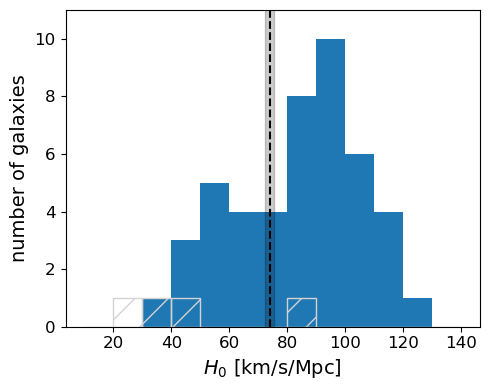

In [52]:
plt.figure(figsize=(5,4), tight_layout=True)

bins = np.arange(10, 150, 10)

plt.hist(100*SGA_0pt['h'][CF4_boolean & ~dwarf_boolean], bins=bins)
plt.hist(100*SGA_0pt['h'][CF4_boolean & dwarf_boolean], bins=bins, facecolor='none', edgecolor='lightgray', hatch='/')

plt.vlines(100*h_measured, 0, 16, 'k', linestyle='dashed')
plt.fill_betweenx([0,16], 100*(h_measured - h_measured_err), 100*(h_measured + h_measured_err), color='k', alpha=0.2)
# plt.vlines(100*h_median, 0, 16, 'k', linestyle='dashed')
# plt.fill_betweenx([0,16], 100*(h_median - h_measured_err), 100*(h_median + h_measured_err), color='k', alpha=0.2)

plt.ylim((0, 11))

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('$H_0$ [km/s/Mpc]', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_H0_hist_20240130.png', 
#             dpi=150, 
#             facecolor='none');

## Do I get a different estimate by fitting a line to the scatter plot?

I'm going to fix the slope to 1, so we're just letting the $y$-intercept float.

In [47]:
def zero_point(b, m, x):
    '''
    Equation of a line
    
    
    PARAMETERS
    ==========
    
    b : float
        y-intercept of line (this is what is being fit for)
    
    m : float
        Slope of line
    
    x : np.ndarray of shape (n,)
        x-values of line
    
    
    RETURNS
    =======
    
    y : np.ndarray of shape (n,)
        y-values calculated with the provided inputs
    '''
    
    y = m*x + b
    
    return y



def calculate_chi2(b, m, x, x_err, y, y_err):
    '''
    Calculate the reduced chi2 value of the current line.
    
    
    PARAMETERS
    ==========
    
    b : float
        y-intercept of the line (this is what is being fit for)
        
    m : floats
        Slope of the line
    
    x, x_err : np.ndarrays of shape (n,)
        x-values and uncertainties in the x-values
    
    y, y_err : np.ndarrays of shape (n,)
        y-values and uncertainties in the y-values
    
    
    RETURNS
    =======
    
    chi2 : float
        Chi2 value of the current best fit (given by b)
    '''
    
    ############################################################################
    # Calculate the values of the current best-fit line
    #---------------------------------------------------------------------------
    y_fit = zero_point(b, m, x)
    ############################################################################
    
    
    ############################################################################
    # Calculate chi2 of current fit
    #---------------------------------------------------------------------------
    chi2 = np.sum((y - y_fit)**2/(y_err**2 + (m*x_err)**2))
    
    #chi2_norm = chi2/(len(x) - 1) # Only one free parameter in this fit
    ############################################################################
    
    return chi2#_norm

In [48]:
b_guess = 0

result = minimize(calculate_chi2, 
                  b_guess, 
                  args=(1, 
                        SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & ~dwarf_boolean], 
                        SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & ~dwarf_boolean], 
                        SGA_0pt['R_ABSMAG_SB26_us'][CF4_boolean & ~dwarf_boolean], 
                        SGA_0pt['R_ABSMAG_SB26_us_err_stat'][CF4_boolean & ~dwarf_boolean]), 
                  bounds=[[-10, 10]])

b_fit = result.x[0]

In [49]:
h = 10**(-0.2*b_fit)

print(f'{h:.2f}')# +/- {h_measured_err:.3f}')

1.02


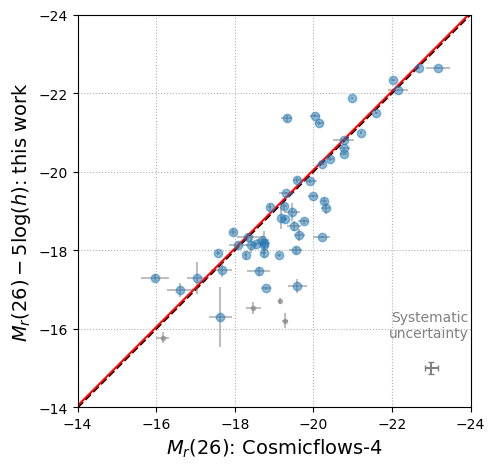

In [50]:
#plt.figure(figsize=(4,4), tight_layout=True)
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.plot([-5, -28], [-5, -28], 'k--')

plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & ~dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_us'][CF4_boolean & ~dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & ~dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_err_stat'][CF4_boolean & ~dwarf_boolean], 
             fmt='o', 
             alpha=0.5, 
             ecolor='gray')
plt.errorbar(SGA_0pt['R_ABSMAG_SB26_CF4'][CF4_boolean & dwarf_boolean], SGA_0pt['R_ABSMAG_SB26_us'][CF4_boolean & dwarf_boolean], 
             xerr=SGA_0pt['R_ABSMAG_SB26_CF4_err_stat'][CF4_boolean & dwarf_boolean], 
             yerr=SGA_0pt['R_ABSMAG_SB26_us_err_stat'][CF4_boolean & dwarf_boolean], 
             fmt='.',
             color='gray',
             alpha=0.5, 
             ecolor='gray')

# Plot fit
plt.plot([-5, -28], [-5, -28] + b_fit, 'r')

# Systematic error bar example
plt.errorbar([-23], [-15], 
             xerr=np.nanmean(SGA_0pt['R_ABSMAG_SB26_CF4_err_sys'][CF4_boolean]),
             yerr=np.nanmean(SGA_0pt['R_ABSMAG_SB26_us_err_sys'][CF4_boolean]), 
             # fmt='x', 
             # color='lightgray',
             ecolor='gray', 
             capsize=2)
plt.annotate('Systematic\nuncertainty', 
             (-23.95, -16.1), 
             #rotation='vertical', 
             va='center',
             ha='right',
             c='gray')

plt.gca().set_aspect('equal')

plt.xlim([-14, -24])
plt.ylim([-14, -24])

plt.xlabel('$M_r(26)$: Cosmicflows-4', fontsize=14)
#plt.ylabel('$M_r(26) - 5\log(h)$: this work (no dwarfs)', fontsize=14);
plt.ylabel('$M_r(26) - 5\log(h)$: this work', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_CF4comp_nodwarf1_20240130.png', 
#             dpi=150, 
#             facecolor='none');